In [391]:
using Plots
#Parameters of the simulation
Nx = 150
Ny = 100
q = 9
ρ₀ = 100.0
τ = 0.6
#Lattice velocities and weights
cx = [0,0,1, 0,-1,1, 1,-1,-1]
cy = [0,1,0,-1, 0,1,-1,-1, 1]
w = [4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36]
#I want a cylinder
function metric(x1,y1,x2,y2)
    return sqrt((x1-x2)^2 + (y1-y2)^2)
end
cylinder = BitArray(metric(i,j,Nx/4,Ny/2) < 20 for i in 1:Nx, j in 1:Ny)

@show μ=ρ₀*(τ-0.5)
#Functions for updating

function feq(ux,uy,ρ)
    f = zeros(Nx,Ny,q)
    for i in 1:q
        cu = 3*(cx[i]*ux + cy[i]*uy)
        f[:,:,i] =   w[i] *ρ .* (1 .+ (cu .* cu)/2 .- 3*(ux.^2 + uy.^2)/2)
    end
    return f
end

function collision(f,ρ,ux,uy)
    f_eq = feq(ux,uy,ρ)
    f = f - (f - f_eq)/τ
    return f
end

#streaming
function streaming(f)
    f_new = zeros(Nx,Ny,q)
    for i in 1:q
        f_new[:,:,i] = circshift(f[:,:,i],(cx[i],cy[i]))
    end
    return f_new
end

function macrovars(f)
    ρ = reshape(sum(f,dims=3),Nx,Ny)
    ux = reshape(sum(f[:,:,i] .* cx[i] for i in 1:q)./ρ,Nx,Ny)
    uy = reshape(sum(f[:,:,i] .* cy[i] for i in 1:q)./ρ,Nx,Ny)
    return ρ,ux,uy
end
function boundarycons(f)
    f[Nx,:,[5,8,9]] = f[Nx-1,:,[5,8,9]]
    f[1,:,[3,6,7]] = f[2,:,[3,6,7]]
    
    return f
end

μ = ρ₀ * (τ - 0.5) = 9.999999999999998


boundarycons (generic function with 1 method)

In [409]:
#Setting initial conditions with a stream to the right + normalizing it to the average density
f=ones(Nx,Ny,q) .+ 0.01*randn(Nx,Ny,q) #some noise to make things a bit spicy
A = zeros(Nx,Ny)
for i =1:Nx
    for j = 1:Ny
        A[i,j] = 2*(1 .+0.2*cos.(8pi*(i)/Nx))
    end
end 
 f[:,:,3] += A
x = 1:Nx
y = 1:Ny
ρ= reshape(sum(f,dims=3),Nx,Ny)
for i =1:q
    f[:,:,i] = f[:,:,i] .* ρ₀ ./ ρ
end

In [410]:

Nt = 1000
strength = zeros(Nx,Ny,Nt)
for i = 1:Nt
    
    ρ,ux,uy = macrovars(f)
    CylBond = f[cylinder,:]
    f[cylinder,:] = CylBond[:,[1,4,5,2,3,8,9,6,7]]
    ux[cylinder] .= 0
    uy[cylinder] .= 0
    f = collision(f,ρ,ux,uy)
    f = streaming(f)
    strength[:,:,i] = sqrt.(ux.^2 + uy.^2)
end
strength[cylinder,:] .= 0;

┌ Info: Saved animation to C:\Users\batti\AppData\Local\Temp\jl_YjEH43QHCR.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\batti\\AppData\\Local\\Temp\\jl_YjEH43QHCR.gif")
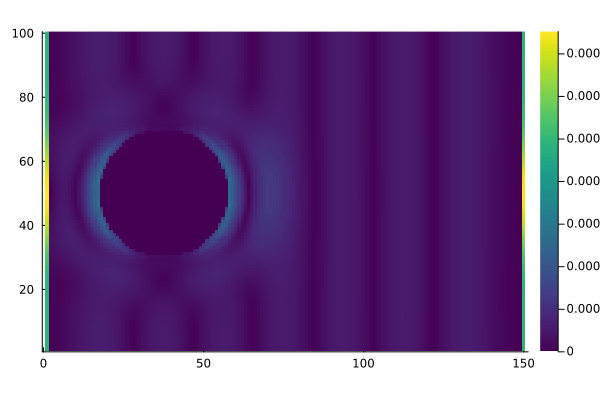

In [396]:
@gif for i = 1:Nt
    heatmap(x,y,transpose(strength[:,:,i]),c=:viridis, aspect_ratio=1)
end

In [407]:
strength[:,:,1] - strength[:,:,3]

150×100 Matrix{Float64}:
  7.28522e-8    7.31899e-8    7.3463e-8    …   7.2086e-8     7.24756e-8
 -3.10396e-10  -2.94309e-10  -2.79977e-10     -3.41829e-10  -3.26661e-10
 -3.35188e-9   -3.33935e-9   -3.32363e-9      -3.3711e-9    -3.36224e-9
 -5.98812e-9   -5.96741e-9   -5.94038e-9      -6.0186e-9    -6.00469e-9
 -7.88645e-9   -7.85871e-9   -7.82146e-9      -7.92533e-9   -7.90791e-9
 -8.77602e-9   -8.74346e-9   -8.69808e-9   …  -8.81858e-9   -8.80008e-9
 -8.46738e-9   -8.43217e-9   -8.38064e-9      -8.50841e-9   -8.4916e-9
 -6.87021e-9   -6.83435e-9   -6.77849e-9      -6.90478e-9   -6.89229e-9
 -3.99635e-9   -3.96125e-9   -3.90217e-9      -4.02043e-9   -4.01453e-9
  4.05191e-11   7.42271e-11   1.36098e-10      2.9542e-11    2.72794e-11
  ⋮                                        ⋱                
 -1.49441e-8   -1.4918e-8    -1.4907e-8       -1.50195e-8   -1.49798e-8
 -1.70443e-8   -1.70266e-8   -1.70245e-8      -1.71055e-8   -1.70726e-8
 -1.75448e-8   -1.75335e-8   -1.75378e-8      -1.